# Food-101 :: [Challenge Link](https://fellowship.ai/challenge)

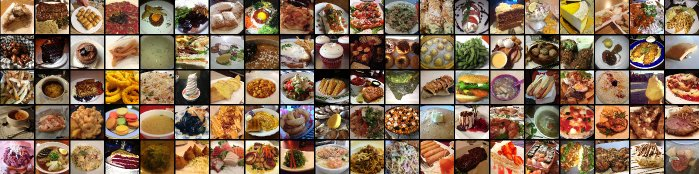


### Problem Statement
<p>
We introduce a challenging data set of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
</p>

### Dataset

[Training and Test dataset](http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz) for the challenge. 
<br>

### Evaluation Metric
 
*** Accuracy ***

In [1]:
%cd ../input/food-101/food-101/
!ls food-101/

/kaggle/input/food-101/food-101
README.txt  images  license_agreement.txt  meta


**meta** folder contains the text files - train.txt and test.txt <br>
**train.txt** contains the list of images that belong to training set <br>
**test.txt** contains the list of images that belong to test set <br>
**classes.txt** contains the list of all classes of food <br>

**images** folder contains 101 folders with 1000 images each. <br>
Following Classes of Food items available

In [2]:
!ls food-101/images/

apple_pie	    eggs_benedict	     onion_rings
baby_back_ribs	    escargots		     oysters
baklava		    falafel		     pad_thai
beef_carpaccio	    filet_mignon	     paella
beef_tartare	    fish_and_chips	     pancakes
beet_salad	    foie_gras		     panna_cotta
beignets	    french_fries	     peking_duck
bibimbap	    french_onion_soup	     pho
bread_pudding	    french_toast	     pizza
breakfast_burrito   fried_calamari	     pork_chop
bruschetta	    fried_rice		     poutine
caesar_salad	    frozen_yogurt	     prime_rib
cannoli		    garlic_bread	     pulled_pork_sandwich
caprese_salad	    gnocchi		     ramen
carrot_cake	    greek_salad		     ravioli
ceviche		    grilled_cheese_sandwich  red_velvet_cake
cheese_plate	    grilled_salmon	     risotto
cheesecake	    guacamole		     samosa
chicken_curry	    gyoza		     sashimi
chicken_quesadilla  hamburger		     scallops
chicken_wings	    hot_and_sour_soup	     seaweed_salad
chocolate_cake	    hot_dog		     shrimp_and_grits
chocolate_mousse    huevo

In [3]:
from collections import defaultdict
from shutil import copy
import os
import gc

# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [4]:
%cd /
print("Creating train data...")
prepare_data('/kaggle/input/food-101/food-101/food-101/meta/train.txt', '/kaggle/input/food-101/food-101/food-101/images', 'train')

/
Creating train data...
Copying Done!


In [5]:
%cd /
print("Creating test data...")
prepare_data('/kaggle/input/food-101/food-101/food-101/meta/test.txt', '/kaggle/input/food-101/food-101/food-101/images', 'test')

/
Creating test data...
Copying Done!


In [6]:
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750
Total number of samples in test folder
25250


In [7]:
from fastai.metrics import accuracy
from fastai.vision import *

BS = 16
SEED = 678
NUM_WORKERS = 0

from pathlib import Path
path = Path('/')

In [8]:
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(678)

tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0., xtra_tfms=[cutout()])

src = (ImageList.from_folder(path/'train')
       .split_by_rand_pct(0.2)
       .label_from_folder())

data = (src.add_test_folder(test_folder = path/'test')              
         .transform(tfms, size=128)
         .databunch(num_workers=NUM_WORKERS,bs=BS)).normalize(imagenet_stats)

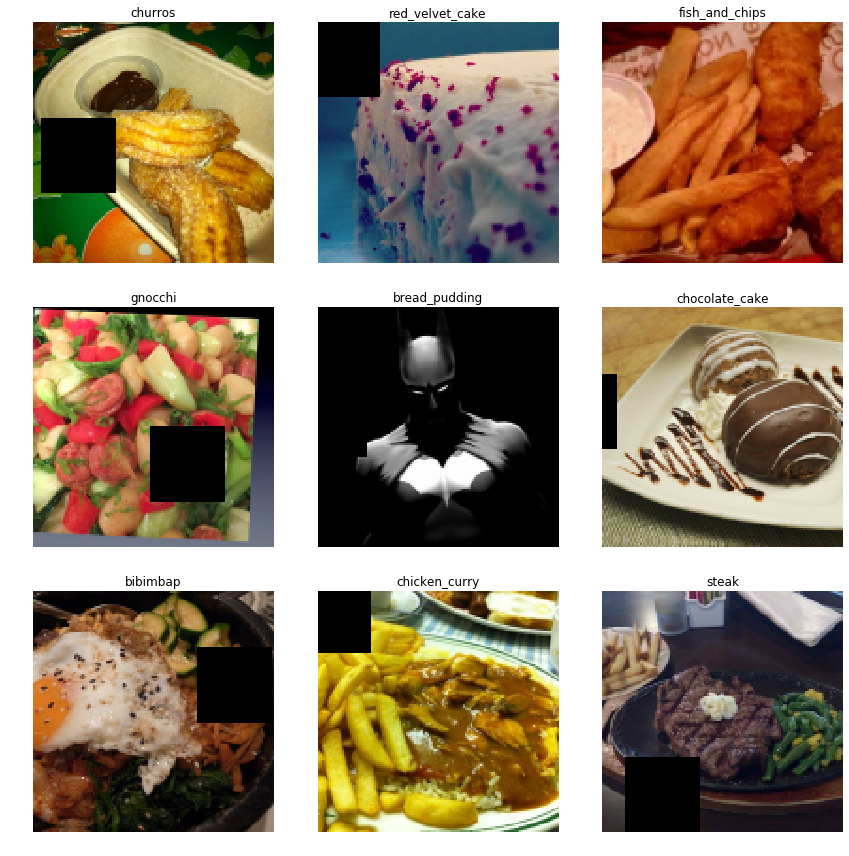

In [9]:
data.show_batch(3)

In [10]:
gc.collect()

learner = cnn_learner(
    data,
    models.resnet50,
    path=path,
    metrics=[accuracy],
    ps = 0.5
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


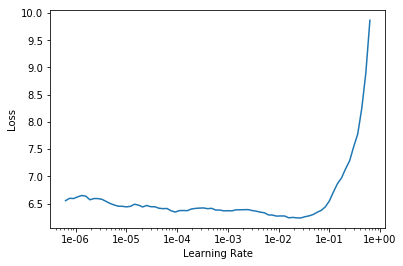

In [11]:
learner.lr_find()
learner.recorder.plot()

In [12]:
lr = 1e-03
learner.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.744425,2.204565,0.454191,16:11


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


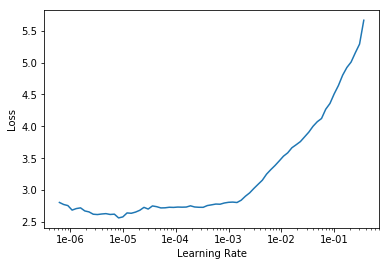

In [13]:
learner.save('stage-1-rn50')
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [14]:
learner.fit_one_cycle(2, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy,time


In [15]:
learner.save('stage-2-rn50')

In [16]:
data = (src.add_test_folder(test_folder = path/'test')              
         .transform(tfms, size=256)
         .databunch(num_workers=NUM_WORKERS,bs=BS)).normalize(imagenet_stats)

learner.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


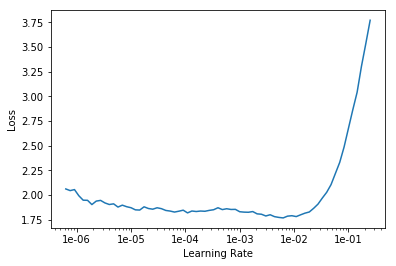

In [17]:
learner.freeze()
learner.lr_find()
learner.recorder.plot()

In [18]:
lr=1e-3/2
learner.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.381328,1.058476,0.727129,19:19


In [19]:
learner.save('stage-1-256-rn50')
learner.unfreeze()
learner.fit_one_cycle(2, slice(1e-6, 1e-5/5))

epoch,train_loss,valid_loss,accuracy,time


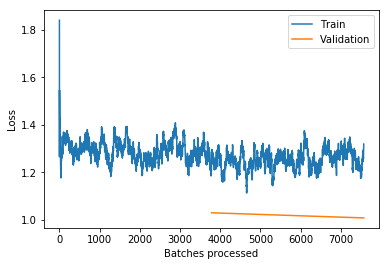

In [20]:
learner.recorder.plot_losses()
learner.save('stage-2-256-rn50')
learner.export()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


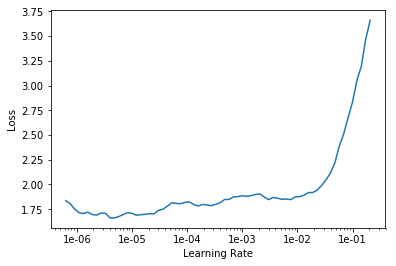

In [21]:
data = (src.add_test_folder(test_folder = path/'test')              
         .transform(tfms, size=512)
         .databunch(num_workers=NUM_WORKERS,bs=BS)).normalize(imagenet_stats)

learner.data = data

learner.freeze()
learner.lr_find()
learner.recorder.plot()

In [22]:
lr=1e-3/2
learner.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.376657,1.076256,0.718350,57:04


In [23]:
learner.save('stage-1-512-rn50')
learner.unfreeze()
learner.fit_one_cycle(2, slice(1e-6, 1e-3/2))

epoch,train_loss,valid_loss,accuracy,time


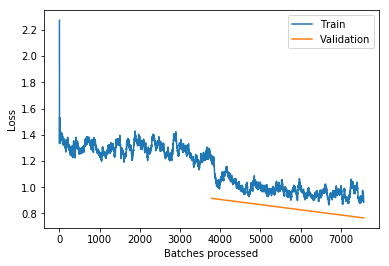

In [24]:
learner.recorder.plot_losses()
learner.save('stage-2-512-rn50')
learner.export()

In [25]:
preds, _ = learner.get_preds(ds_type=DatasetType.Test)